In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

titanic = pd.DataFrame.from_csv('titanic3.csv')

In [2]:
"Preprocessing the data"
df_sliced = titanic[["survived","sex","age","pclass","fare","sibsp","parch"]]
df_sliced = df_sliced.dropna(axis=0, how='any')
sex = {'male':1,'female':0}
df_sliced['sex'] = df_sliced['sex'].map(sex)

X = np.array(df_sliced[["sex","age","pclass","fare","sibsp","parch"]])
y = np.array(df_sliced["survived"])

In [3]:
"Exploratory Data Analysis"
def EDA_1():
    sns.countplot(x="sex", hue="survived", data=titanic,palette="Set1")
    plt.show()
    sns.countplot(x="pclass", hue="survived", data=titanic,palette="GnBu_d")
    plt.show()
    sns.barplot(x="sex", y="survived", hue="pclass", data=titanic,palette="Reds")
    plt.show()
    
def EDA_2(): 
    sns.violinplot(x="survived", y="age", hue="sex", data=titanic,
               split=True, palette="Set2")
    plt.show()
    sns.swarmplot(x="survived", y="age", hue="sex", data=titanic)
    plt.show()
    sns.swarmplot(x="survived", y="age", hue="pclass", data=titanic)
    plt.show()

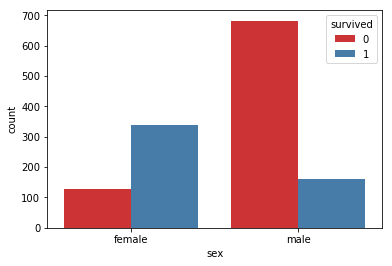

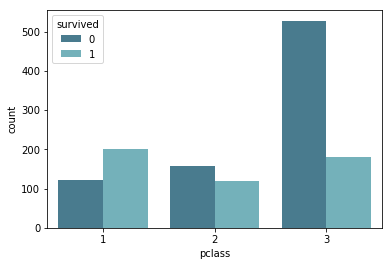

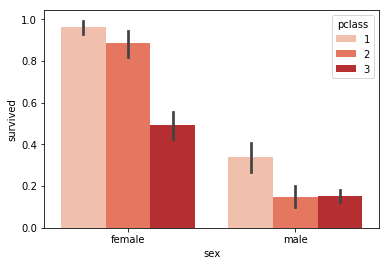

In [4]:
EDA_1()

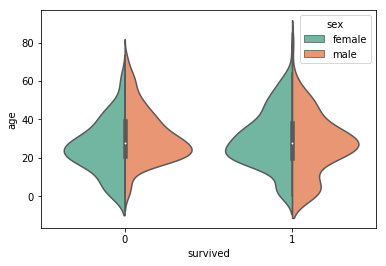

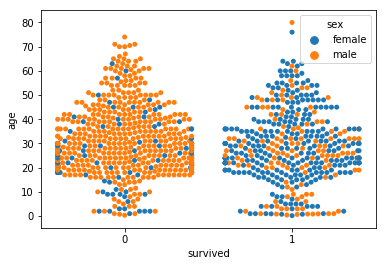

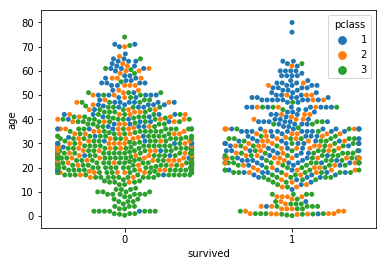

In [5]:
EDA_2()
"""From the swarmplot, we can see that children (age udner 20) were more proabable to survive than the elder.
Male were less likely to survive than women, and those who were in better cabin class were more likely to survive."""

In [6]:
"KNN compare parameter K (note: random_state set to 1 for searching K) and the n in n-fold cross-validation"
def KNN_choose_K(X,y,K): 
    # Import necessary modules
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split
    
    # Split into training and test set, stratify the split according to the labels so that they are distributed in the training and test sets as they are in the original dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)
    
    # Setup arrays to store train and test accuracies
    neighbors = np.arange(1, K)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    # Loop over different values of k
    for i, k in enumerate(neighbors):
        # Setup a k-NN Classifier with k neighbors: knn
        knn = KNeighborsClassifier(n_neighbors=k)
        # Fit the classifier to the training data
        knn.fit(X_train,y_train)    
        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train, y_train)
        #Compute accuracy on the testing set
        test_accuracy[i] = knn.score(X_test, y_test)
    # Generate plot
    plt.title('k-NN: Varying Number of Neighbors')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()


def KNN_CrossValid(X,y,K,CV):
    # Import necessary modules
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_val_score
    # Split into training and test set, stratify the split according to the labels so that they are distributed in the training and test sets as they are in the original dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,  stratify=y)
    knn = KNeighborsClassifier(n_neighbors=K)
    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    accuracy = knn.score(X_test, y_test)   
    cv_Nfold = cross_val_score(knn, X, y, cv=CV)
    # Import necessary modules
    #print(accuracy)
    #print(cv_Nfold)
    #print(np.mean(cv_Nfold))
    return accuracy, np.mean(cv_Nfold)

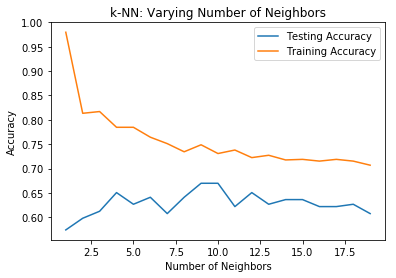

In [7]:
"Try 20 Ks for the model"
KNN_choose_K(X,y,20)

In [9]:
"""I decide to use K=10 in KNN model, and now, the cross_valid function returns the accuracy of KNN model under 
given K and the mean of accuracy for N cross-validation result given K."""
KNN_CrossValid(X,y,10,20)

(0.67942583732057416, 0.65169647684908505)

In [10]:
"Logistic regression"
def logit_CrossValid(X,y,CV):
    from sklearn.model_selection import train_test_split
    # Import the necessary modules
    from sklearn.linear_model import LogisticRegression

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    # Create the classifier: logreg
    logreg = LogisticRegression()
    logreg.fit(X_train,y_train)
    
    # Import necessary modules
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import roc_auc_score
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = logreg.predict_proba(X_test)[:,1]
    # Compute cross-validated AUC scores: cv_auc
    cv_auc = cross_val_score(logreg, X, y, cv=CV, scoring='roc_auc')
    
    return roc_auc_score(y_test, y_pred_prob), np.mean(cv_auc)

In [11]:
"This serves the same process as what I did with KNN model, and it's clear that logistic regression performs better."
logit_CrossValid(X,y,20)

(0.79454209065679926, 0.86150735465251604)

In [12]:
"Model simulation"
def KNN_simulate(X,y,K,CV,n):
    accuracy = np.empty(n)
    CV_N_fold = np.empty(n)
    
    for i in range(0,n):
        accuracy[i], CV_N_fold[i] = KNN_CrossValid(X,y,K,CV)
    print("Accuracy without CV:",np.mean(accuracy))
    print("Accuracy with CV:",np.mean(CV_N_fold))
    
def logit_simulate(X,y,CV,n):
    AUC = np.empty(n)
    CV_N_fold = np.empty(n)
    
    for i in range(0,n):
        AUC[i], CV_N_fold[i] = logit_CrossValid(X,y,CV)
    print("AUC without CV:",np.mean(AUC))
    print("AUC with CV:",np.mean(CV_N_fold))

In [13]:
"Model comparison (With 100 times simulation and 20-fold cross-validation for each model)"
KNN_simulate(X,y,10,20,100)
logit_simulate(X,y,20,100)

Accuracy without CV: 0.668038277512
Accuracy with CV: 0.651696476849
AUC without CV: 0.840032496997
AUC with CV: 0.861507354653
